In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from scipy import stats

***1. Chargement des données***

In [2]:
df = pd.read_csv('Telco-Churn.csv')

**------------ -------------**

***2. Analyse Exploratoire des données (EDA)***

**2.1. Overview**

In [3]:
print(df.info()) #Types des données et compter les valeurs non-nulles

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [4]:
print(df.describe()) #Afficher les tendances centrales de colomnes numériques

       SeniorCitizen       tenure  MonthlyCharges
count    7043.000000  7043.000000     7043.000000
mean        0.162147    32.371149       64.761692
std         0.368612    24.559481       30.090047
min         0.000000     0.000000       18.250000
25%         0.000000     9.000000       35.500000
50%         0.000000    29.000000       70.350000
75%         0.000000    55.000000       89.850000
max         1.000000    72.000000      118.750000


**2.2. Distirbution des Classes**

In [5]:
print("---- CHURN DISTRIBUTION ------")
print(df['Churn'].value_counts(normalize=True) * 100)

---- CHURN DISTRIBUTION ------
Churn
No     73.463013
Yes    26.536987
Name: proportion, dtype: float64


*2.2.1. Diagramme Circulaire de la distribution des classes*

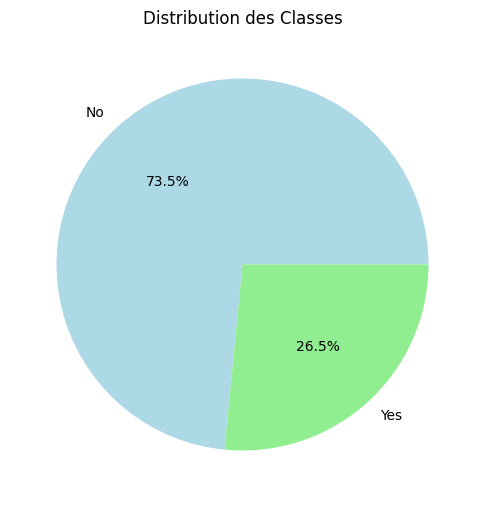

In [6]:
plt.figure(figsize=(6,7))
df['Churn'].value_counts().plot.pie(labels=['No' ,'Yes'],colors=['lightblue' ,'lightgreen'] ,autopct='%1.1f%%')
plt.title('Distribution des Classes')
plt.ylabel('')
plt.show()

**2.3. Visualisation des variables**

*2.3.1. Variables numériques*

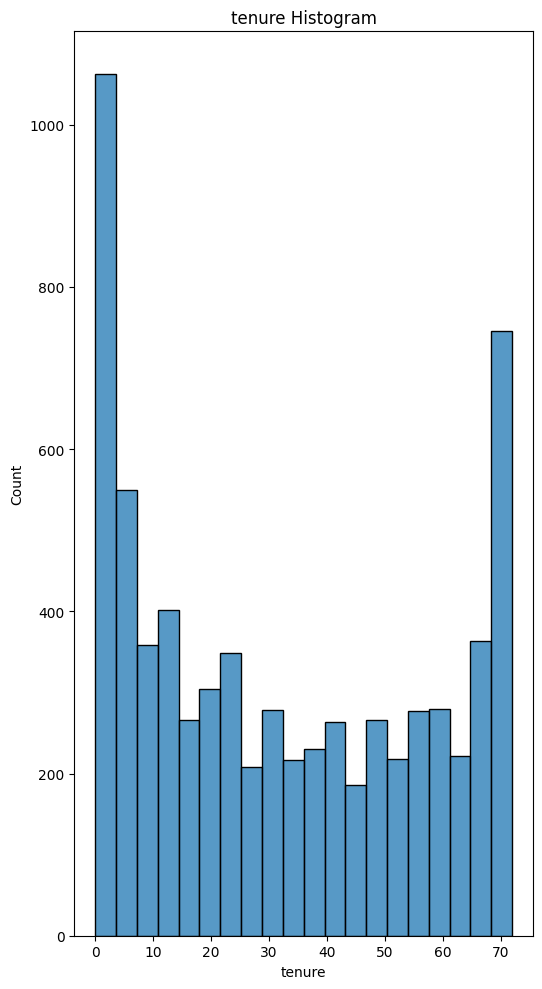

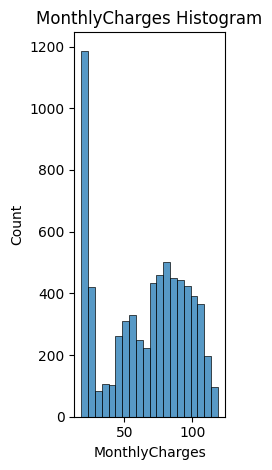

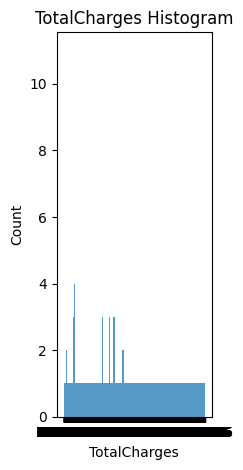

In [7]:
num_vars = ['tenure' ,'MonthlyCharges' ,'TotalCharges']
plt.figure(figsize=(15 ,10))
for i ,col in enumerate(num_vars ,1):
    plt.subplot(1 ,3 ,i)
    sns.histplot(df[col] ,bins=20)
    plt.title(f'{col} Histogram')
    plt.tight_layout()
    plt.show()

*2.3.2. Variables categorielles*

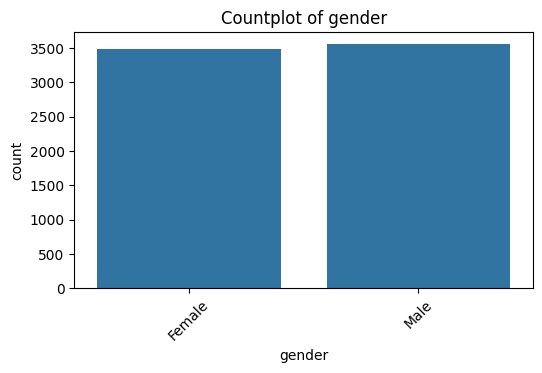

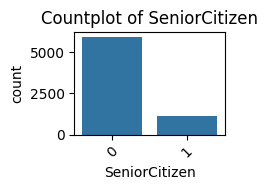

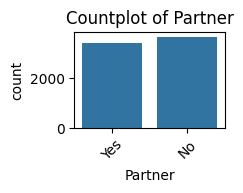

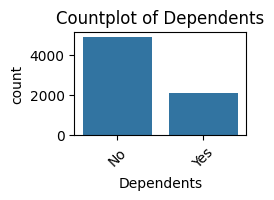

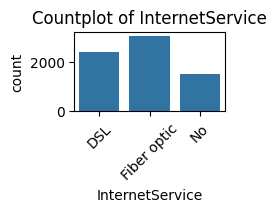

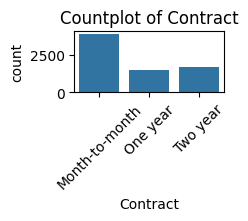

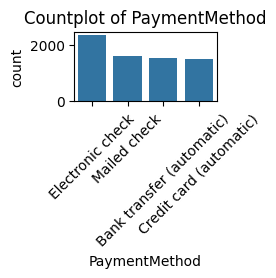

In [8]:
categorical_cols = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'InternetService', 'Contract', 'PaymentMethod']

plt.figure(figsize=(15, 10))
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(3 ,3 ,i)
    sns.countplot(x=col, data=df)
    plt.title(f'Countplot of {col}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


**2.4. Analyse des facteurs influencant le Churn**

*2.4.1. Influence des variables numériques sur le Churn*

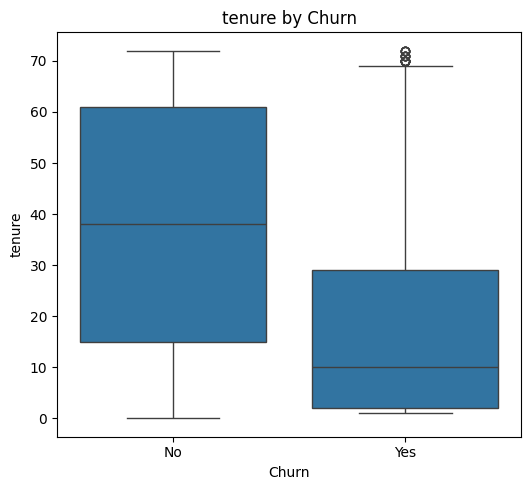

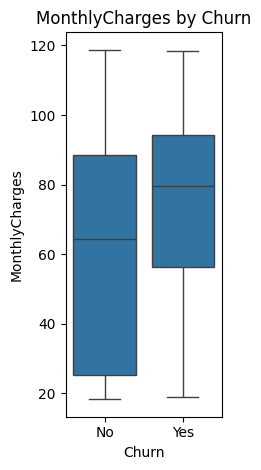

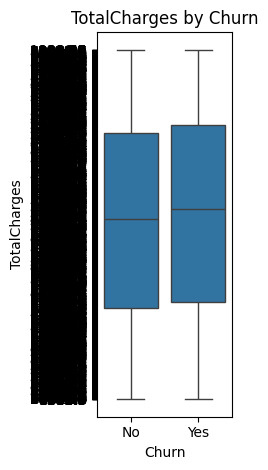

In [9]:
plt.figure(figsize=(15, 5))
for i, col in enumerate(num_vars, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(x='Churn', y=col, data=df)
    plt.title(f'{col} by Churn')
    plt.tight_layout()
    plt.show()


*2.4.2. Influence des variables cartégorielles sur le Churn*

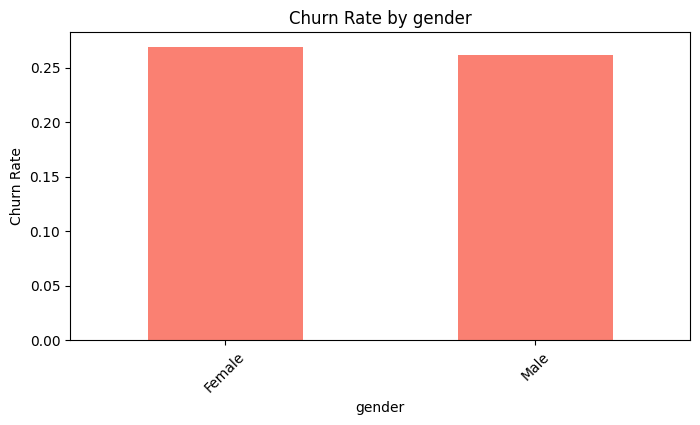

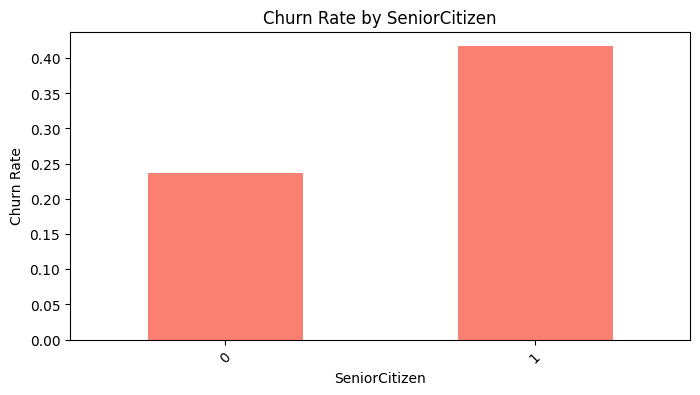

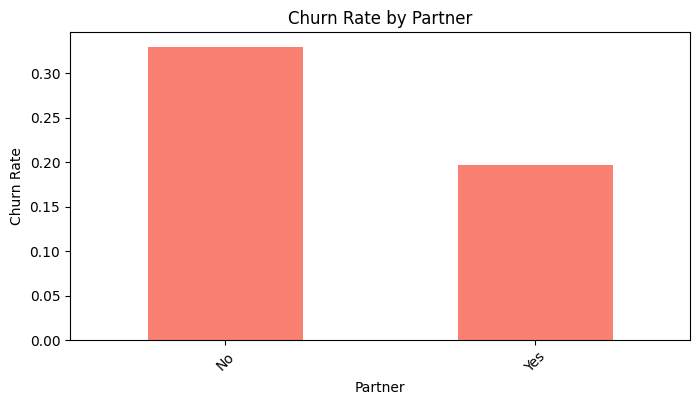

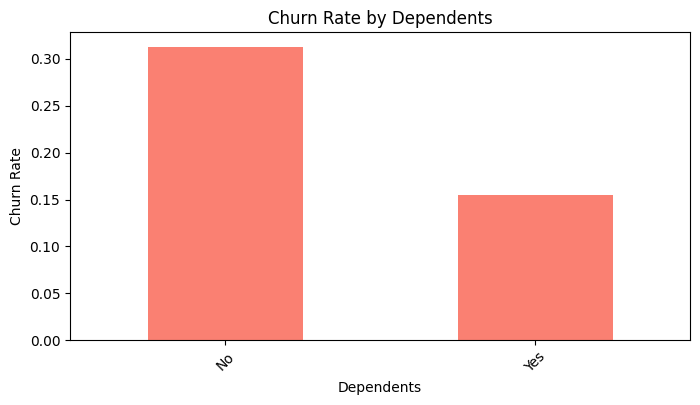

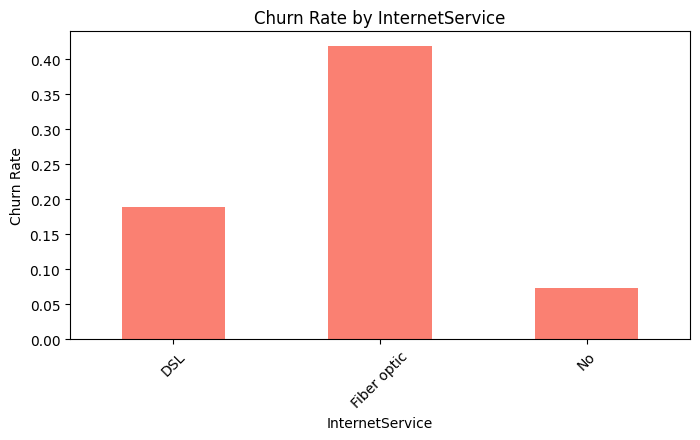

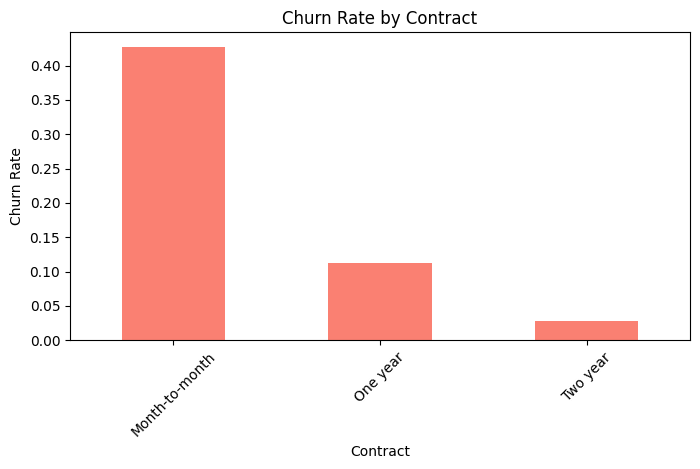

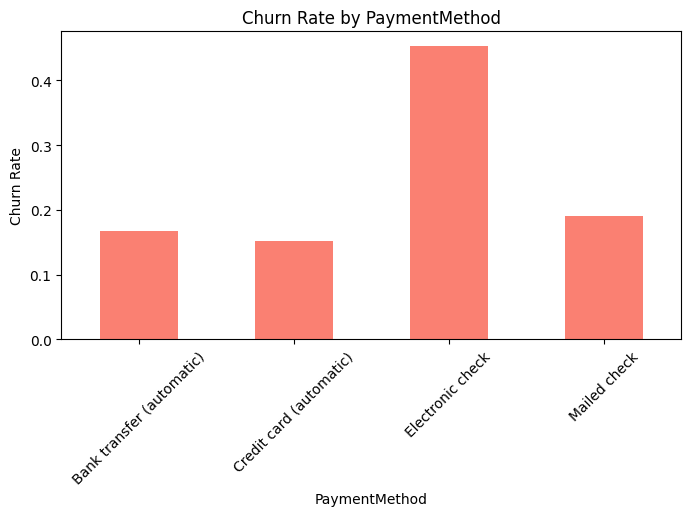

In [10]:
for col in categorical_cols:
    churn_rate = df.groupby(col)['Churn'].value_counts(normalize=True).unstack().fillna(0)['Yes']
    plt.figure(figsize=(8, 4))
    churn_rate.plot(kind='bar', color='salmon')
    plt.title(f'Churn Rate by {col}')
    plt.ylabel('Churn Rate')
    plt.xticks(rotation=45)
    plt.show()

**------------ -------------**

***3. Prétraitement des données***

**3.1. Nettoyage des données**

*3.1.1. Suppression de la colonne 'customer ID'*

In [11]:
df = df.drop(['customerID'], axis=1)

In [12]:
print("Nombre de valeurs manquantes par colonne:\n", df.isnull().sum())

Nombre de valeurs manquantes par colonne:
 gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


⚠️ Aucune des colonnes contient des valeurs manquantes, MAIS les valeurs manquantes sont affichées en type int64 et pourtant des colonnes tel que 'TotalCharges' utilisent des strings et peuvent contenir des strings vides ' '⚠️

In [13]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

In [14]:
print("Nombre de valeurs manquantes par colonne:\n", df.isnull().sum())

Nombre de valeurs manquantes par colonne:
 gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64


❌ La colonne 'TotalCharges' contient 11 NaNs

In [15]:
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())

In [16]:
print("Valeurs manquantes aprés nettoyage:\n", df.isnull().sum())

Valeurs manquantes aprés nettoyage:
 gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


✅ Et voila le travail !

**3.2. Normalisation et Scaling**

In [17]:
X = df.drop('Churn', axis=1)
y = df['Churn']
scaler = StandardScaler()
X[num_vars] = scaler.fit_transform(X[num_vars])

**3.3. Encodage**

*3.3.1 Encodage des valeurs categorielles en numériques binaires*

In [18]:
binary_cols = ['gender', 'Partner', 'Dependents', 'PhoneService',
                'PaperlessBilling', 'Churn']
le = LabelEncoder()
for col in binary_cols:
    df[col] = le.fit_transform(df[col])

*3.3.1 Encodage des valeurs categorielles multi-classes en numériques (OneHotEncoder)*

In [19]:
multi_cols = ['MultipleLines', 'InternetService', 'OnlineSecurity',
               'OnlineBackup', 'DeviceProtection','TechSupport',
               'StreamingTV', 'StreamingMovies', 'Contract', 
                              'PaymentMethod']
df = pd.get_dummies(df, columns=multi_cols, drop_first=True)  

In [20]:
print("Données après encodage:\n", df.head())

Données après encodage:
    gender  SeniorCitizen  Partner  Dependents  tenure  PhoneService  \
0       0              0        1           0       1             0   
1       1              0        0           0      34             1   
2       1              0        0           0       2             1   
3       1              0        0           0      45             0   
4       0              0        0           0       2             1   

   PaperlessBilling  MonthlyCharges  TotalCharges  Churn  ...  \
0                 1           29.85         29.85      0  ...   
1                 0           56.95       1889.50      0  ...   
2                 1           53.85        108.15      1  ...   
3                 0           42.30       1840.75      0  ...   
4                 1           70.70        151.65      1  ...   

   TechSupport_Yes  StreamingTV_No internet service  StreamingTV_Yes  \
0            False                            False            False   
1            

In [21]:
print("Types des données après encodage:\n", df.dtypes)
print()
print("Dimensions des données après encodage:", df.shape)

Types des données après encodage:
 gender                                     int64
SeniorCitizen                              int64
Partner                                    int64
Dependents                                 int64
tenure                                     int64
PhoneService                               int64
PaperlessBilling                           int64
MonthlyCharges                           float64
TotalCharges                             float64
Churn                                      int64
MultipleLines_No phone service              bool
MultipleLines_Yes                           bool
InternetService_Fiber optic                 bool
InternetService_No                          bool
OnlineSecurity_No internet service          bool
OnlineSecurity_Yes                          bool
OnlineBackup_No internet service            bool
OnlineBackup_Yes                            bool
DeviceProtection_No internet service        bool
DeviceProtection_Yes              

**3.4. PCA**

In [22]:
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(df.drop('Churn', axis=1))

In [26]:
print("Nombre de composantes PCA:", pca.n_components_)
print("Ratio de variance expliquée par chaque composante:", pca.explained_variance_ratio_)

Nombre de composantes PCA: 1
Ratio de variance expliquée par chaque composante: [0.99986001]


**3.5. Divsion du Dataset (Training /Test)**

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42, stratify=y)
print("Taille du jeu d'entraînement:", X_train.shape)
print("Taille du jeu de test:", X_test.shape)

Taille du jeu d'entraînement: (5634, 1)
Taille du jeu de test: (1409, 1)


**------------ -------------**

***4. Validation Croisée***

In [32]:
models = {
    'KNN': KNeighborsClassifier(),  
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42)
}

for name, model in models.items():
    print(f"---- {name} ----")

---- KNN ----
---- Naive Bayes ----
---- Decision Tree ----
---- Random Forest ----


**4.1. Validation Croisée avec k=5**

In [33]:
cv5_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
print(f"CV = 5 Scores: {cv5_scores}")
print(f"CV5 Mean Accuracy: {cv5_scores.mean():.4f}")

CV = 5 Scores: [0.63886424 0.63442768 0.63708962 0.65394854 0.65452931]
CV5 Mean Accuracy: 0.6438


**4.2. Validation Croisée avec k=10**

In [34]:
cv10_scores = cross_val_score(model, X_train, y_train, cv=10, scoring='accuracy')
print(f"CV = 10 Scores: {cv10_scores}")
print(f"CV10 Mean Accuracy: {cv10_scores.mean():.4f}")

CV = 10 Scores: [0.64716312 0.63297872 0.64007092 0.63120567 0.63765542 0.62877442
 0.6749556  0.63943162 0.64831261 0.63410302]
CV10 Mean Accuracy: 0.6415
